In [1]:
import cellpose
import dask.array as da
import napari
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

### Load images from zarr 

In [2]:
gfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch1.zarr/')
rfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch2.zarr/')

### Compress z-stacks into maximum projections

In [3]:
gfp = da.sum(gfp, axis = 1)
rfp = da.sum(rfp, axis = 1)

In [4]:
gfp

dask.array<sum-aggregate, shape=(75, 6048, 6048), dtype=uint64, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


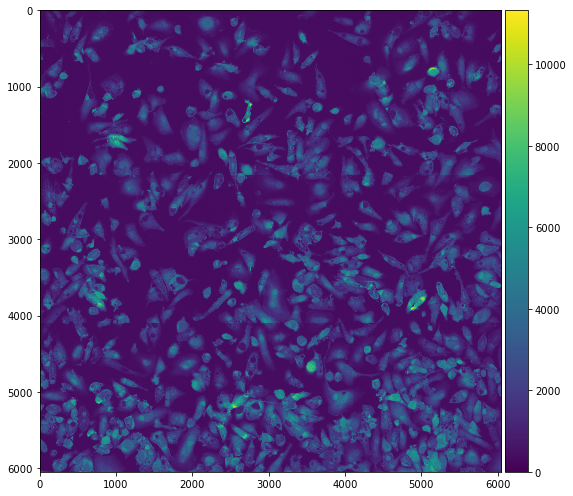

In [5]:
imshow(gfp[0])

## Save out first frame as tiff for testing default cellpose GUI on 

# Cellpose segmentation - CPU


In [6]:
# !nvcc --version
# !nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

# use_GPU = core.use_gpu()
# yn = ['NO', 'YES']
# print(f'>>> GPU activated? {yn[use_GPU]}')

### Define example 1ch gfp first ten frames max projection image

In [7]:
gfp

dask.array<sum-aggregate, shape=(75, 6048, 6048), dtype=uint64, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

In [8]:
%%time
# define model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='cyto')
# define CHANNELS to run segementation on
channels = [0,0]
### define empty mask stack 
mask_stack = []
### iterate over frames
for frame in tqdm(gfp, total = len(gfp)):
    ### run segmentation
    masks, flows, styles, diams = model.eval(frame, diameter=None, flow_threshold=None, channels=channels)
    ### append to mask stack
    mask_stack.append(masks)

  0%|          | 0/75 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Using CPU takes 495s/frame i.e. 8mins, approx. 8 times slower than GPU

# Now looking at parallelising the process 

In [2]:
import os
import ipyparallel as ipp

cluster = ipp.Cluster(n=4)
with cluster as rc:
    ar = rc[:].apply_async(os.getpid)
    pid_map = ar.get_dict()

AttributeError: module 'ipyparallel' has no attribute 'Cluster'

In [1]:
from IPython import parallel
rc = parallel.Client()
dv = rc[:]
rc.ids

ImportError: cannot import name 'parallel' from 'IPython' (/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/IPython/__init__.py)

# conclusion: no way is this going to be quicker than just handing the image processsing off to the GPU